This notebook shows the visualizations of different calendars that can be generated with switchback splitters

In [1]:
from cluster_experiments import PowerAnalysis
import pandas as pd
import numpy as np
import plotnine as pn
# Remove warnings
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

pn.theme_set(pn.theme_minimal())

In [2]:
def plot_calendar(splitter, df, calendar_name):
    treatments = splitter.assign_treatment_df(df)
    
    treatment_df = (
        treatments
        .loc[:, ["city", "treatment", "time"]]
        .drop_duplicates()
    )
    # Convert time column to datetime format and extract week and day
    treatment_df['week_number'] = treatment_df['time'].dt.isocalendar().week.astype(int).astype(str)
    treatment_df['week_number_num'] = treatment_df['time'].dt.isocalendar().week
    # add time with the week set to the minimum week number
    treatment_df['time_in_week'] = treatment_df['time'] - pd.to_timedelta(treatment_df['week_number_num'], unit='W') + pd.to_timedelta(treatment_df['week_number_num'].min(), unit='W')

    # Custom date formatter function
    def custom_date_formatter(dates):
        return [date.strftime('%a %H:%M') for date in dates]

    # Create the plot
    plot = (
        pn.ggplot(treatment_df, pn.aes(x='time_in_week', y='week_number', fill='treatment'))
        + pn.geom_tile()
        + pn.theme_minimal()
        + pn.labs(
            title=f"Treatment assignment using {calendar_name}",
            x="Time since start of week",
            y="Week number",
            fill="Treatment"
        )
        + pn.facet_wrap('~city')
        + pn.scale_x_datetime(labels=custom_date_formatter)
        # vertical labels
        + pn.theme(axis_text_x=pn.element_text(angle=90, vjust=1.0))
    )

    # Display the plot
    return plot

In [3]:
# Define data with random dates
df_raw = pd.DataFrame(
    {   
        "time": pd.date_range("2021-03-01", "2021-03-15", freq="1s")[
            np.random.randint(14 * 24 * 60 * 60, size=14 * 24 * 60 * 60)
        ],
        "y": np.random.randn(14 * 24 * 60 * 60),
    }
).assign(
    day_of_week=lambda df: df.time.dt.dayofweek,
    hour_of_day=lambda df: df.time.dt.hour,
    hour_4h=lambda df: df.time.dt.hour // 4,
    week=lambda df: df.time.dt.isocalendar().week,
)
df = pd.concat([df_raw.assign(city=city) for city in ("TGN", "NYC", "LON", "REU")])

In [4]:
# We have data of 2-weeks in 4 cities
df.head()

,time,y,day_of_week,hour_of_day,hour_4h,week,city
0,2021-03-02 09:52:38,0.328784,1,9,2,9,TGN
1,2021-03-08 18:25:55,0.489899,0,18,4,10,TGN
2,2021-03-02 12:38:52,-0.559446,1,12,3,9,TGN
3,2021-03-03 23:59:38,1.644260,2,23,5,9,TGN
4,2021-03-02 06:37:48,-0.418535,1,6,1,9,TGN


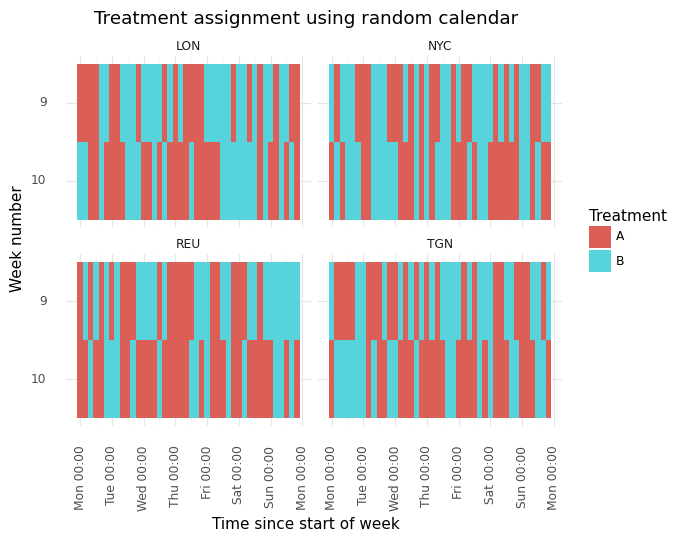

<ggplot: (313058539)>

In [5]:
# Completely random calendar
from datetime import timedelta


config = {
    "time_col": "time",
    "switch_frequency": "4h",
    "perturbator": "uniform",
    "analysis": "ols_clustered",
    "splitter": "switchback",
    "cluster_cols": ["time", "city"],
    "target_col": "y",
    "washover": "constant_washover",
    "washover_time_delta": timedelta(hours=2),
}

power = PowerAnalysis.from_dict(config)

plot_calendar(power.splitter, df, "random calendar")

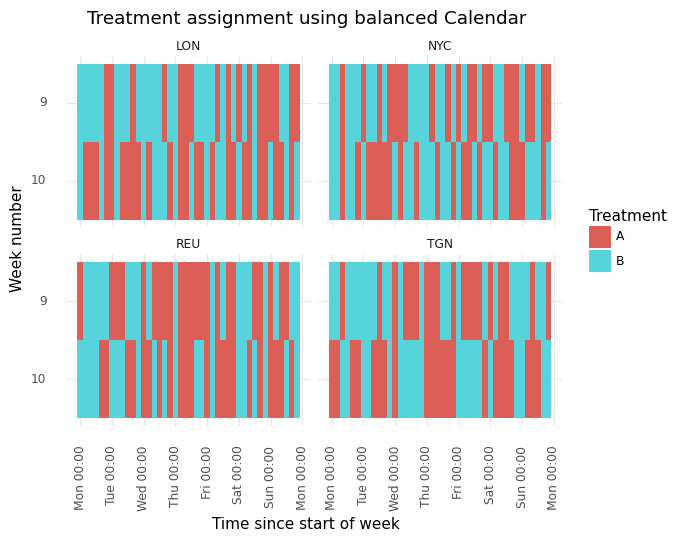

<ggplot: (313263833)>

In [6]:
# Balanced calendar
config = {
    "time_col": "time",
    "switch_frequency": "4h",
    "perturbator": "uniform",
    "analysis": "ols_clustered",
    "splitter": "switchback_balance",
    "cluster_cols": ["time", "city"],
    "target_col": "y",
}

power = PowerAnalysis.from_dict(config)

plot_calendar(power.splitter, df, "balanced Calendar")

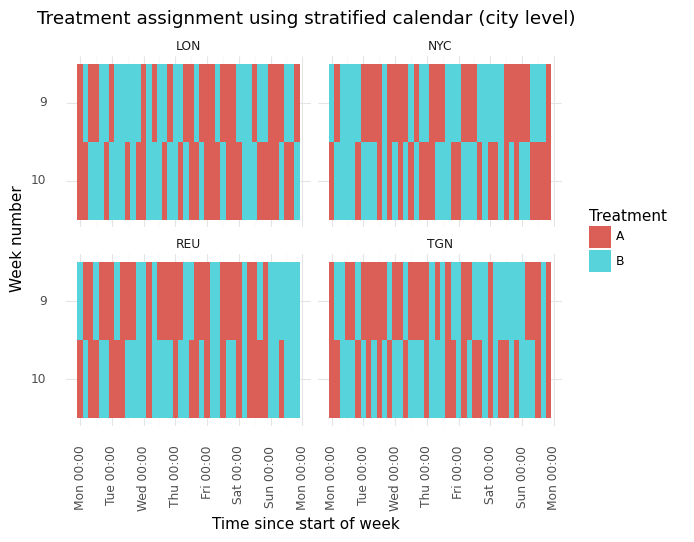

<ggplot: (313411560)>

In [7]:
# Stratified - city level
config = {
    "time_col": "time",
    "switch_frequency": "4h",
    "perturbator": "uniform",
    "analysis": "ols_clustered",
    "splitter": "switchback_stratified",
    "cluster_cols": ["time", "city"],
    "strata_cols": ["city"],
    "target_col": "y",
}

power = PowerAnalysis.from_dict(config)

plot_calendar(power.splitter, df, "stratified calendar (city level)")

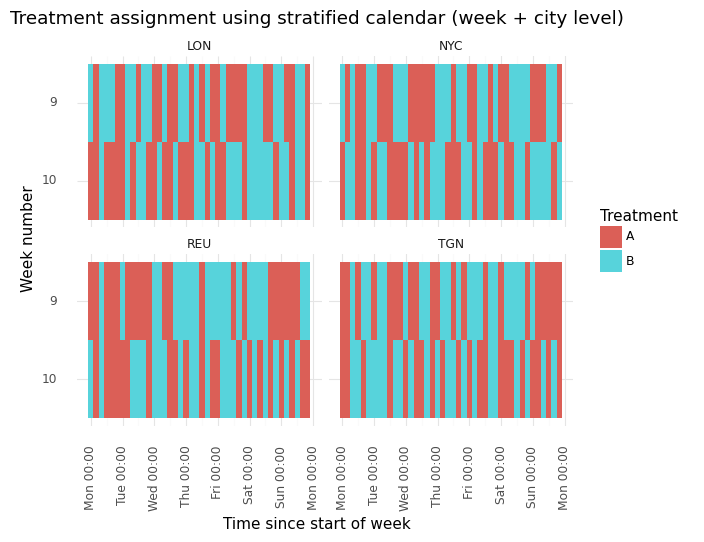

<ggplot: (313062545)>

In [8]:
# Stratified - city + week level
config = {
    "time_col": "time",
    "switch_frequency": "4h",
    "perturbator": "uniform",
    "analysis": "ols_clustered",
    "splitter": "switchback_stratified",
    "cluster_cols": ["time", "city"],
    "strata_cols": ["week", "city"],
    "target_col": "y",
}

power = PowerAnalysis.from_dict(config)

plot_calendar(power.splitter, df, "stratified calendar (week + city level)")

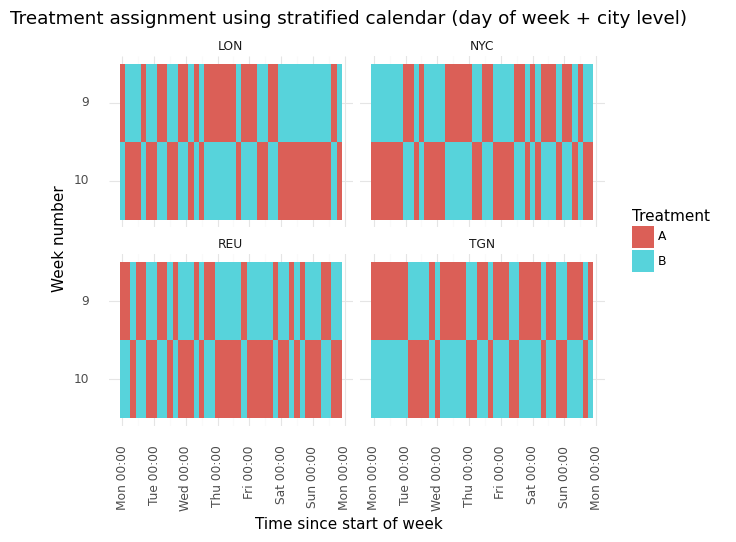

<ggplot: (313682929)>

In [9]:
# Stratified - city + day of week level
config = {
    "time_col": "time",
    "switch_frequency": "4h",
    "perturbator": "uniform",
    "analysis": "ols_clustered",
    "splitter": "switchback_stratified",
    "cluster_cols": ["time", "city"],
    "strata_cols": ["day_of_week", "hour_4h", "city"],
    "target_col": "y",
}

power = PowerAnalysis.from_dict(config)

plot_calendar(power.splitter, df, "stratified calendar (day of week + city level)")